# Reinforcement Learning: Hello World

## Using AWS SageMaker for RL

AWS SageMaker allows you to train your RL agents in cloud machines using docker containers. You do not have to worry about setting up your machines with the RL toolkits and deep learning frameworks. You can easily switch between many different machines setup for you, including powerful GPU machines that give a big speedup. You can also choose to use multiple machines in a cluster to further speedup training, often necessary for production level loads.

### Prerequisites 

#### Imports

To get started, we'll import the Python libraries we need, set up the environment with a few prerequisites for permissions and configurations.

In [1]:
import sagemaker
import boto3
import sys
import os
import glob
import re
import subprocess
from IPython.display import HTML
import time
from time import gmtime, strftime
sys.path.append("common")
from misc import get_execution_role, wait_for_s3_object
from sagemaker.rl import RLEstimator, RLToolkit, RLFramework

#### Settings

Let's define a few configuration settings and values we will use later in the notebook.

In [2]:
env_type = 'simple-corridor'

# create unique job name 
job_name_prefix = 'rl-' + env_type

# S3 bucket
sage_session = sagemaker.session.Session()
s3_bucket = sage_session.default_bucket()  
s3_output_path = 's3://{}/'.format(s3_bucket)
print("S3 bucket path: {}".format(s3_output_path))

S3 bucket path: s3://sagemaker-us-east-1-273210948404/


#### Create an IAM role
Either get the execution role when running from a SageMaker notebook `role = sagemaker.get_execution_role()` or, when running from local machine, use utils method `role = get_execution_role('role_name')` to create an execution role.

In [3]:
try:
    role = sagemaker.get_execution_role()
except:
    role = get_execution_role()

print("Using IAM role arn: {}".format(role))

Using IAM role arn: arn:aws:iam::273210948404:role/onica-aiml-workshop-ExecutionRole-U2CRSU9PTJ0Y


#### Setup the environment

The environment is defined in a Python file called “simple_corridor_env.py” and the file is uploaded on /src directory. 

The environment also implements the init(), step(), reset() and render() functions that describe how the environment behaves. This is consistent with Open AI Gym interfaces for defining an environment. 


1. Init() - initialize the environment in a pre-defined state
2. Step() - take an action on the environment
3. reset()- restart the environment on a new episode
4. render() - get a rendered image of the environment in its current state

#### Configure the presets for RL algorithm 

The presets that configure the RL training jobs are defined in the “preset-tsp-easy.py” file which is also uploaded on the /src directory. Using the preset file, you can define agent parameters to select the specific agent algorithm. You can also set the environment parameters, define the schedule and visualization parameters, and define the graph manager. The schedule presets will define the number of heat up steps, periodic evaluation steps, training steps between evaluations.

These can be overridden at runtime by specifying the RLCOACH_PRESET hyperparameter. Additionally, it can be used to define custom hyperparameters. 

In [4]:
!pygmentize src/preset-simple-corridor.py

from rl_coach.agents.clipped_ppo_agent import ClippedPPOAgentParameters
from rl_coach.environments.gym_environment import GymVectorEnvironment
from rl_coach.graph_managers.basic_rl_graph_manager import BasicRLGraphManager
from rl_coach.graph_managers.graph_manager import SimpleSchedule
from rl_coach.core_types import *
#from rl_coach.environments.environment import SelectedPhaseOnlyDumpMethod, MaxDumpMethod
from rl_coach import logger
from rl_coach.base_parameters import TaskParameters
from rl_coach.base_parameters import VisualizationParameters
from rl_coach.architectures.embedder_parameters import InputEmbedderParameters

################
#  Environment #
################

env_params = GymVectorEnvironment(level='simple_corridor_env:SimpleCorridor')

#########
# Agent #
#########

agent_params = ClippedPPOAgentParameters()

#################
# Visualization #
#################

#env_params.frame_skip = 5 #to make sure the gifs work without skipping steps

vis_params = VisualizationPa

#### Write the Training Code 

The training code is written in the file “train-coach.py” which is uploaded in the /src directory. 
First import the environment files and the preset files, and then define the main() function. 

In [5]:
!pygmentize src/train-coach-simple-corridor.py

from sagemaker_rl.coach_launcher import SageMakerCoachPresetLauncher


class MyLauncher(SageMakerCoachPresetLauncher):

    def default_preset_name(self):
        """This points to a .py file that configures everything about the RL job.
        It can be overridden at runtime by specifying the RLCOACH_PRESET hyperparameter.
        """
        return 'preset-simple-corridor'

    def map_hyperparameter(self, name, value):
        """Here we configure some shortcut names for hyperparameters that we expect to use frequently.
        Essentially anything in the preset file can be overridden through a hyperparameter with a name 
        like "rl.agent_params.algorithm.etc".  
        """
        # maps from alias (key) to fully qualified coach parameter (value)
        mapping = {
                      "discount": "rl.agent_params.algorithm.discount",
                      "evaluation_episodes": "rl.evaluation_steps:EnvironmentEpisodes",
                      "improve_steps": "rl.improve_s

### Train the RL model using the Python SDK Script mode

If you are using local mode, the training will run on the notebook instance. When using SageMaker for training, you can select a GPU or CPU instance. The RLEstimator is used for training RL jobs. 

1. Specify the source directory where the environment, presets and training code is uploaded.
2. Specify the entry point as the training code 
3. Specify the choice of RL toolkit and framework. This automatically resolves to the ECR path for the RL Container. 
4. Define the training parameters such as the instance count, job name, S3 path for output and job name. 
5. Specify the hyperparameters for the RL agent algorithm. The RLCOACH_PRESET or the RLRAY_PRESET can be used to specify the RL agent algorithm you want to use. 
6. Define the metrics definitions that you are interested in capturing in your logs. These can also be visualized in CloudWatch and SageMaker Notebooks. 

In [6]:
%%time

estimator = RLEstimator(entry_point="train-coach-simple-corridor.py",
                        source_dir='src',
                        dependencies = ["common/sagemaker_rl"],
                        toolkit=RLToolkit.COACH,
                        toolkit_version='0.11',
                        framework=RLFramework.TENSORFLOW,
                        role=role,
                        train_instance_type='ml.m4.4xlarge',
                        train_instance_count=1,
                        output_path=s3_output_path,
                        base_job_name=job_name_prefix,
                        hyperparameters = {
                          #expected run time 12 mins for TSP Easy  
                          "RLCOACH_PRESET": "preset-" + env_type, 
                        }
                    )

estimator.fit(wait=False)

CPU times: user 102 ms, sys: 7.51 ms, total: 110 ms
Wall time: 433 ms


### Store intermediate training output and model checkpoints 

The output from the training job above is stored on S3. The intermediate folder contains gifs and metadata of the training.

In [7]:
job_name=estimator._current_job_name

print("Job name: {}".format(job_name))

s3_url = "s3://{}/{}".format(s3_bucket,job_name)

output_tar_key = "{}/output/output.tar.gz".format(job_name)

intermediate_folder_key = "{}/output/intermediate".format(job_name)
output_url = "s3://{}/{}".format(s3_bucket, output_tar_key)
intermediate_url = "s3://{}/{}".format(s3_bucket, intermediate_folder_key)

print("S3 job path: {}".format(s3_url))
print("Output.tar.gz location: {}".format(output_url))
print("Intermediate folder path: {}".format(intermediate_url))
    
tmp_dir = "/tmp/{}".format(job_name)
os.system("mkdir {}".format(tmp_dir))
print("Create local folder {}".format(tmp_dir))

Job name: rl-simple-corridor-2019-06-26-23-34-10-674
S3 job path: s3://sagemaker-us-east-1-273210948404/rl-simple-corridor-2019-06-26-23-34-10-674
Output.tar.gz location: s3://sagemaker-us-east-1-273210948404/rl-simple-corridor-2019-06-26-23-34-10-674/output/output.tar.gz
Intermediate folder path: s3://sagemaker-us-east-1-273210948404/rl-simple-corridor-2019-06-26-23-34-10-674/output/intermediate
Create local folder /tmp/rl-simple-corridor-2019-06-26-23-34-10-674


### Visualization

#### Comparing against a baseline policy

#### Plot metrics for training job
We can pull the reward metric of the training and plot it to see the performance of the model over time.

Waiting for s3://sagemaker-us-east-1-273210948404/rl-simple-corridor-2019-06-26-23-34-10-674/output/intermediate/worker_0.simple_rl_graph.main_level.main_level.agent_0.csv...


Text(0.5, 0, 'Episode #')

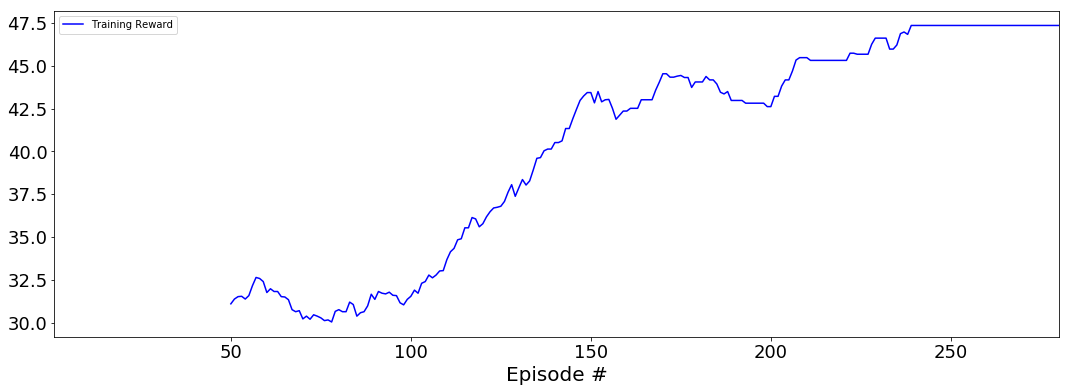

In [12]:
import pandas as pd
import matplotlib
%matplotlib inline

# csv_file has all the RL training metrics
# csv_file = "{}/worker_0.simple_rl_graph.main_level.main_level.agent_0.csv".format(tmp_dir)
csv_file_name = "worker_0.simple_rl_graph.main_level.main_level.agent_0.csv"
key = intermediate_folder_key + "/" + csv_file_name
wait_for_s3_object(s3_bucket, key, tmp_dir)

csv_file = "{}/{}".format(tmp_dir, csv_file_name)
df = pd.read_csv(csv_file)
x_axis = 'Episode #'
y_axis_rl = 'Training Reward'
df[y_axis_rl] = df[y_axis_rl].rolling(50).mean()
ax = df.plot(x=x_axis,y=y_axis_rl, figsize=(18,6), fontsize=18, legend=True, color='b')
fig = ax.get_figure()
ax.set_xlabel(x_axis,fontsize=20)
#ax.set_ylabel(y_axis,fontsize=20)
#fig.savefig('training_reward_vs_wall_clock_time.pdf')

### Evaluation of RL models

We use the last checkpointed model to run evaluation for the RL Agent. 

#### Load checkpointed model

Checkpointed data from the previously trained models will be passed on for evaluation / inference in the checkpoint channel. In local mode, we can simply use the local directory, whereas in the SageMaker mode, it needs to be moved to S3 first.

In [13]:
%%time

wait_for_s3_object(s3_bucket, output_tar_key, tmp_dir)  

if not os.path.isfile("{}/output.tar.gz".format(tmp_dir)):
    raise FileNotFoundError("File output.tar.gz not found")
os.system("tar -xvzf {}/output.tar.gz -C {}".format(tmp_dir, tmp_dir))


checkpoint_dir = "{}/checkpoint".format(tmp_dir)

print("Checkpoint directory {}".format(checkpoint_dir))

Waiting for s3://sagemaker-us-east-1-273210948404/rl-simple-corridor-2019-06-26-23-34-10-674/output/output.tar.gz...
Checkpoint directory /tmp/rl-simple-corridor-2019-06-26-23-34-10-674/checkpoint
CPU times: user 173 ms, sys: 35.3 ms, total: 208 ms
Wall time: 611 ms


In [14]:
%%time

checkpoint_path = "s3://{}/{}/checkpoint/".format(s3_bucket, job_name)
if not os.listdir(checkpoint_dir):
    raise FileNotFoundError("Checkpoint files not found under the path")
os.system("aws s3 cp --recursive {} {}".format(checkpoint_dir, checkpoint_path))
print("S3 checkpoint file path: {}".format(checkpoint_path))

S3 checkpoint file path: s3://sagemaker-us-east-1-273210948404/rl-simple-corridor-2019-06-26-23-34-10-674/checkpoint/
CPU times: user 5.16 ms, sys: 0 ns, total: 5.16 ms
Wall time: 1.56 s


#### Run the evaluation step

Use the checkpointed model to run the evaluation step. 

In [ ]:
estimator_eval = RLEstimator(role=role,
                             source_dir='src/',
                             dependencies = ["common/sagemaker_rl"],
                             toolkit=RLToolkit.COACH,
                             toolkit_version='0.11.0',
                             framework=RLFramework.TENSORFLOW,
                             entry_point="evaluate-coach.py",
                             train_instance_count=1,
                             train_instance_type='ml.m4.4xlarge',
                             hyperparameters = {
                                 "RLCOACH_PRESET": "preset-simple-corridor",
                                 "evaluate_steps": 200, #max 4 episodes
                             }
                            )

estimator_eval.fit({'checkpoint': checkpoint_path})

2019-06-26 23:40:00 Starting - Starting the training job...
2019-06-26 23:40:03 Starting - Launching requested ML instances......
2019-06-26 23:41:09 Starting - Preparing the instances for training...
2019-06-26 23:41:57 Downloading - Downloading input data...
2019-06-26 23:42:26 Training - Training image download completed. Training in progress..
bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2019-06-26 23:42:28,014 sagemaker-containers INFO     Imported framework sagemaker_tensorflow_container.training
2019-06-26 23:42:28,017 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2019-06-26 23:42:35,340 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2019-06-26 23:42:35,352 sagemaker-containers INFO     Invoking user script

Training Env:

{
    "additional_framework_parameters": {
        "sagemaker_estimator": "RLEstimator"
    },
    "channel_input_dirs": {
        "